# Modelling tabular data
> After completing the data retrieval and cleaning we here deal with how to set up basic models.

In [ ]:
#default_exp modelling

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
import pandas as pd
from fastai2.tabular.all import *
from fastai2 import metrics
from sklearn import ensemble
import pickle
from kaggle_house_prices.utils import *
from kaggle_house_prices.preprocessing import *

## Setting up the `TabularDataLoader`

The data loader is required to feed data into the learner during training

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
# df_s = pd.read_csv(clean_data_path, encoding="utf8")

In [ ]:
df_s = pd.read_feather(clean_data_path_feather).set_index("index")

In [ ]:
#hide
display_all(df_s.head().T)

index,939,921,1,603,1453
Id,940,922,2,604,1454
MSSubClass,70,90,20,160,20
MSZoning,RL,RL,RL,FV,RL
LotFrontage,69,67,80,30,90
LotArea,24090,8777,9600,3182,17217
Street,Pave,Pave,Pave,Pave,Pave
Alley,NA,NA,NA,Pave,NA
LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


Transforming `dep_var` to log space

In [ ]:
if df_s[dep_var].dtype != "float64":
    df_s[dep_var] = df_s[dep_var].apply(float)

Get `splits` object for `TabularPandas`

In [ ]:
splits = ColSplitter(col="valid")(df_s)

Set up the [`TabularPandas`](https://dev.fast.ai/tabular.core#TabularPandas) object

In [ ]:
to = TabularPandas(df_s, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=dep_var, splits=splits)

In [ ]:
#hide
display_all(df_s.iloc[splits[1]][cat_names].head())

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotArea_na,YearBuilt_na,YearRemodAdd_na,MasVnrArea_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,1stFlrSF_na,2ndFlrSF_na,GrLivArea_na,GarageYrBlt_na,GarageArea_na,WoodDeckSF_na,OpenPorchSF_na,LotFrontage_na
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103,104,20,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,GasA,Ex,Y,SBrkr,0.0,0,0,2,0,3,1,Gd,6,Typ,0,NA,Attchd,RFn,3,TA,TA,Y,0,0,0,0,NA,NA,NA,0,5,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
915,916,160,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,GasA,Fa,Y,SBrkr,0.0,0,0,1,1,3,1,TA,6,Typ,0,NA,Attchd,Unf,1,TA,TA,Y,0,0,0,0,NA,NA,NA,0,1,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1284,1285,50,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,6,7,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,PConc,TA,TA,No,Unf,0.0,Unf,GasA,Ex,Y,SBrkr,0.0,0,0,2,0,4,1,Gd,10,Min2,1,Gd,Detchd,Unf,1,TA,TA,Y,42,0,116,0,NA,NA,NA,0,3,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1309,1310,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,Gd,TA,No,GLQ,1200.0,Unf,GasA,Gd,Y,SBrkr,0.0,1,0,2,0,3,1,Gd,6,Typ,0,NA,Attchd,RFn,2,TA,TA,Y,0,0,0,0,NA,GdWo,NA,0,6,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
525,526,20,FV,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,GasA,Ex,Y,SBrkr,0.0,0,0,2,0,3,1,Gd,6,Typ,1,TA,Attchd,Unf,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,4,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
#hide
display_all(to.valid.xs[cat_names].head())

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotArea_na,YearBuilt_na,YearRemodAdd_na,MasVnrArea_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,1stFlrSF_na,2ndFlrSF_na,GrLivArea_na,GarageYrBlt_na,GarageArea_na,WoodDeckSF_na,OpenPorchSF_na,LotFrontage_na
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103,104,1,4,2,2,1,4,1,1,1,6,3,3,1,3,7,5,2,2,13,14,4,4,5,3,3,5,5,7,1,7,2,1,2,6,1,1,1,3,1,4,2,3,5,7,1,4,2,3,4,6,6,3,1,1,1,1,4,5,2,1,5,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
915,916,13,5,2,2,4,4,1,5,1,11,3,3,4,6,4,5,2,2,6,6,2,4,5,2,5,5,5,7,1,7,2,2,2,6,1,1,1,2,2,4,2,4,5,7,1,4,2,4,2,6,6,3,1,1,1,1,4,5,2,1,1,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1284,1285,5,4,2,2,4,4,1,5,1,19,2,3,1,1,6,7,2,2,14,16,4,4,5,3,5,5,5,7,1,7,2,1,2,6,1,1,1,3,1,5,2,3,9,4,2,3,6,4,2,6,6,3,12,1,11,1,4,5,2,1,3,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1309,1310,1,4,2,2,4,4,1,5,1,21,3,3,1,3,6,5,2,2,7,7,2,4,5,2,3,5,5,3,54,7,2,3,2,6,1,2,1,3,1,4,2,3,5,7,1,4,2,3,3,6,6,3,1,1,1,1,4,2,2,1,6,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
525,526,1,2,2,3,4,4,1,5,1,22,3,3,1,3,7,5,2,2,13,14,4,3,5,3,3,5,5,7,1,7,2,1,2,6,1,1,1,3,1,4,2,3,5,7,2,6,2,4,3,6,6,3,1,1,1,1,4,5,2,1,4,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Going over categorical mappings where `Categorify` did not make one-hot encodings sanity checking train and validation set encodings

In [ ]:
for col in cat_names:
    print(f"\nColumn: {col}")
    _df = (pd.DataFrame({"original-train": df_s.iloc[splits[0]][col], "categorified-train": to.train.xs[col]})
           .drop_duplicates()
           .sort_values("categorified-train"))
    display_all(_df.head())
    _df = (pd.DataFrame({"original-valid": df_s.iloc[splits[1]][col], "categorified-valid": to.valid.xs[col]})
           .drop_duplicates()
           .sort_values("categorified-valid"))
    display_all(_df.head())
    
#     break


Column: Id


,original-train,categorified-train
index,,
1,2,2
7,8,8
14,15,15
28,29,29
56,57,57


,original-valid,categorified-valid
index,,
29,30,30
103,104,104
210,211,211
266,267,267
347,348,348



Column: MSSubClass


,original-train,categorified-train
index,,
1,20,1
1212,30,2
826,45,4
1411,50,5
1354,60,6


,original-valid,categorified-valid
index,,
103,20,1
29,30,2
1284,50,5
602,60,6
1440,70,7



Column: MSZoning


,original-train,categorified-train
index,,
603,FV,2
671,RH,3
939,RL,4
420,RM,5


,original-valid,categorified-valid
index,,
525,FV,2
103,RL,4
915,RM,5



Column: Street


,original-train,categorified-train
index,,
939,Pave,2


,original-valid,categorified-valid
index,,
103,Pave,2



Column: Alley


,original-train,categorified-train
index,,
314,Grvl,1
939,NA,2
603,Pave,3


,original-valid,categorified-valid
index,,
991,Grvl,1
103,NA,2
525,Pave,3



Column: LotShape


,original-train,categorified-train
index,,
1354,IR1,1
939,Reg,4


,original-valid,categorified-valid
index,,
103,IR1,1
915,Reg,4



Column: LandContour


,original-train,categorified-train
index,,
601,Bnk,1
159,HLS,2
533,Low,3
939,Lvl,4


,original-valid,categorified-valid
index,,
1440,Bnk,1
266,HLS,2
103,Lvl,4



Column: Utilities


,original-train,categorified-train
index,,
939,AllPub,1


,original-valid,categorified-valid
index,,
103,AllPub,1



Column: LotConfig


,original-train,categorified-train
index,,
159,Corner,1
346,CulDSac,2
1,FR2,3
939,Inside,5


,original-valid,categorified-valid
index,,
103,Corner,1
1008,CulDSac,2
266,FR2,3
915,Inside,5



Column: LandSlope


,original-train,categorified-train
index,,
939,Gtl,1
533,Mod,2


,original-valid,categorified-valid
index,,
103,Gtl,1
1332,Mod,2



Column: Neighborhood


,original-train,categorified-train
index,,
465,Blmngtn,1
533,BrkSide,4
939,ClearCr,5
1354,CollgCr,6
955,Crawfor,7


,original-valid,categorified-valid
index,,
29,BrkSide,4
371,ClearCr,5
103,CollgCr,6
1440,Crawfor,7
1332,Edwards,8



Column: Condition1


,original-train,categorified-train
index,,
671,Artery,1
921,Feedr,2
939,Norm,3
1161,PosN,5


,original-valid,categorified-valid
index,,
991,Artery,1
1284,Feedr,2
103,Norm,3



Column: Condition2


,original-train,categorified-train
index,,
939,Norm,3
1230,RRAe,6


,original-valid,categorified-valid
index,,
103,Norm,3
29,RRNn,8



Column: BldgType


,original-train,categorified-train
index,,
939,1Fam,1
969,2fmCon,2
921,Duplex,3
56,Twnhs,4
603,TwnhsE,5


,original-valid,categorified-valid
index,,
103,1Fam,1
915,Twnhs,4
1368,TwnhsE,5



Column: HouseStyle


,original-train,categorified-train
index,,
921,1.5Fin,1
826,1.5Unf,2
1,1Story,3
939,2Story,6
420,SFoyer,7


,original-valid,categorified-valid
index,,
1284,1.5Fin,1
103,1Story,3
1440,2.5Fin,4
915,2Story,6



Column: OverallQual


,original-train,categorified-train
index,,
533,1,1
1212,4,4
921,5,5
1,6,6
939,7,7


,original-valid,categorified-valid
index,,
915,4,4
719,5,5
1284,6,6
103,7,7
602,8,8



Column: OverallCond


,original-train,categorified-train
index,,
533,3,3
242,4,4
603,5,5
671,6,6
939,7,7


,original-valid,categorified-valid
index,,
371,4,4
103,5,5
1332,6,6
1284,7,7
991,9,9



Column: RoofStyle


,original-train,categorified-train
index,,
939,Gable,2
671,Gambrel,3
346,Hip,4
1230,Shed,6


,original-valid,categorified-valid
index,,
103,Gable,2
1008,Hip,4



Column: RoofMatl


,original-train,categorified-train
index,,
939,CompShg,2
629,WdShngl,8


,original-valid,categorified-valid
index,,
103,CompShg,2



Column: Exterior1st


,original-train,categorified-train
index,,
1381,BrkFace,4
1451,CemntBd,6
1194,HdBoard,7
939,MetalSd,9
754,Plywood,10


,original-valid,categorified-valid
index,,
915,CemntBd,6
1309,HdBoard,7
1332,MetalSd,9
210,Stucco,12
103,VinylSd,13



Column: Exterior2nd


,original-train,categorified-train
index,,
1156,BrkFace,4
1451,CmentBd,6
1194,HdBoard,7
284,ImStucc,8
939,MetalSd,9


,original-valid,categorified-valid
index,,
915,CmentBd,6
1309,HdBoard,7
1332,MetalSd,9
719,Plywood,11
210,Stucco,13



Column: MasVnrType


,original-train,categorified-train
index,,
56,BrkFace,2
939,None,4
174,Stone,5


,original-valid,categorified-valid
index,,
915,BrkFace,2
103,None,4
1008,Stone,5



Column: ExterQual


,original-train,categorified-train
index,,
533,Fa,2
603,Gd,3
939,TA,4


,original-valid,categorified-valid
index,,
389,Ex,1
525,Gd,3
103,TA,4



Column: ExterCond


,original-train,categorified-train
index,,
533,Fa,2
939,Gd,3
921,TA,5


,original-valid,categorified-valid
index,,
991,Gd,3
103,TA,5



Column: Foundation


,original-train,categorified-train
index,,
671,BrkTil,1
939,CBlock,2
603,PConc,3
533,Slab,4


,original-valid,categorified-valid
index,,
1440,BrkTil,1
915,CBlock,2
103,PConc,3



Column: BsmtQual


,original-train,categorified-train
index,,
1142,Ex,1
935,Fa,2
1,Gd,3
533,NA,4
939,TA,5


,original-valid,categorified-valid
index,,
1440,Ex,1
103,Gd,3
371,NA,4
915,TA,5



Column: BsmtCond


,original-train,categorified-train
index,,
174,Fa,1
420,Gd,2
533,NA,3
939,TA,5


,original-valid,categorified-valid
index,,
371,NA,3
103,TA,5



Column: BsmtExposure


,original-train,categorified-train
index,,
188,Av,1
1,Gd,2
939,Mn,3
533,NA,4
921,No,5


,original-valid,categorified-valid
index,,
1368,Av,1
719,Gd,2
1332,Mn,3
371,NA,4
103,No,5



Column: BsmtFinType1


,original-train,categorified-train
index,,
921,ALQ,1
1411,BLQ,2
1354,GLQ,3
314,LwQ,4
533,NA,5


,original-valid,categorified-valid
index,,
1332,ALQ,1
991,BLQ,2
1309,GLQ,3
371,NA,5
210,Rec,6



Column: BsmtFinSF1


,original-train,categorified-train
index,,
939,0.0,1
314,16.0,2
62,24.0,3
159,57.0,4
906,63.0,5


,original-valid,categorified-valid
index,,
1332,690.0,0
602,789.0,0
719,523.0,0
1368,685.0,0
991,216.0,0



Column: BsmtFinType2


,original-train,categorified-train
index,,
577,ALQ,1
7,BLQ,2
754,LwQ,4
533,NA,5
1230,Rec,6


,original-valid,categorified-valid
index,,
371,NA,5
103,Unf,7



Column: Heating


,original-train,categorified-train
index,,
939,GasA,2


,original-valid,categorified-valid
index,,
103,GasA,2



Column: HeatingQC


,original-train,categorified-train
index,,
939,Ex,1
533,Fa,2
921,Gd,3
671,TA,5


,original-valid,categorified-valid
index,,
103,Ex,1
915,Fa,2
1309,Gd,3
719,TA,5



Column: CentralAir


,original-train,categorified-train
index,,
671,N,1
939,Y,2


,original-valid,categorified-valid
index,,
29,N,1
103,Y,2



Column: Electrical


,original-train,categorified-train
index,,
242,FuseA,1
533,FuseF,2
939,SBrkr,6


,original-valid,categorified-valid
index,,
210,FuseA,1
103,SBrkr,6



Column: LowQualFinSF


,original-train,categorified-train
index,,
939,0.0,1
1173,479.0,2


,original-valid,categorified-valid
index,,
1440,384.0,0
103,0.0,1



Column: BsmtFullBath


,original-train,categorified-train
index,,
939,0,1
1354,1,2
921,2,3


,original-valid,categorified-valid
index,,
103,0,1
1309,1,2



Column: BsmtHalfBath


,original-train,categorified-train
index,,
939,0,1
1,1,2
597,2,3


,original-valid,categorified-valid
index,,
103,0,1



Column: FullBath


,original-train,categorified-train
index,,
188,0,1
1453,1,2
939,2,3
1142,3,4


,original-valid,categorified-valid
index,,
915,1,2
103,2,3



Column: HalfBath


,original-train,categorified-train
index,,
939,0,1
603,1,2
921,2,3


,original-valid,categorified-valid
index,,
103,0,1
915,1,2



Column: BedroomAbvGr


,original-train,categorified-train
index,,
533,1,2
603,2,3
1,3,4
939,4,5


,original-valid,categorified-valid
index,,
1368,1,2
1332,2,3
103,3,4
1284,4,5



Column: KitchenAbvGr


,original-train,categorified-train
index,,
939,1,2
921,2,3


,original-valid,categorified-valid
index,,
103,1,2



Column: KitchenQual


,original-train,categorified-train
index,,
1451,Ex,1
533,Fa,2
603,Gd,3
939,TA,4


,original-valid,categorified-valid
index,,
389,Ex,1
29,Fa,2
103,Gd,3
915,TA,4



Column: TotRmsAbvGrd


,original-train,categorified-train
index,,
533,2,1
1078,3,2
603,4,3
754,5,4
1,6,5


,original-valid,categorified-valid
index,,
1332,3,2
1368,4,3
719,5,4
103,6,5
1008,7,6



Column: Functional


,original-train,categorified-train
index,,
1173,Maj1,1
1411,Min2,4
939,Typ,7


,original-valid,categorified-valid
index,,
1440,Min1,3
1284,Min2,4
103,Typ,7



Column: Fireplaces


,original-train,categorified-train
index,,
921,0,1
1,1,2
939,2,3


,original-valid,categorified-valid
index,,
103,0,1
1284,1,2
347,2,3



Column: FireplaceQu


,original-train,categorified-train
index,,
1017,Ex,1
14,Fa,2
1451,Gd,3
921,NA,4
939,TA,6


,original-valid,categorified-valid
index,,
389,Ex,1
1284,Gd,3
103,NA,4
719,Po,5
525,TA,6



Column: GarageType


,original-train,categorified-train
index,,
913,2Types,1
939,Attchd,2
1142,BuiltIn,4
603,Detchd,6
921,NA,7


,original-valid,categorified-valid
index,,
103,Attchd,2
389,BuiltIn,4
1284,Detchd,6
210,NA,7



Column: GarageFinish


,original-train,categorified-train
index,,
56,Fin,1
921,NA,2
1,RFn,3
939,Unf,4


,original-valid,categorified-valid
index,,
602,Fin,1
210,NA,2
103,RFn,3
915,Unf,4



Column: GarageCars


,original-train,categorified-train
index,,
921,0,1
939,1,2
1,2,3
1354,3,4
420,4,5


,original-valid,categorified-valid
index,,
210,0,1
915,1,2
1309,2,3
103,3,4



Column: GarageQual


,original-train,categorified-train
index,,
314,Fa,2
921,NA,4
939,TA,6


,original-valid,categorified-valid
index,,
1332,Fa,2
210,NA,4
103,TA,6



Column: GarageCond


,original-train,categorified-train
index,,
921,NA,4
939,TA,6


,original-valid,categorified-valid
index,,
1332,Fa,2
210,NA,4
103,TA,6



Column: PavedDrive


,original-train,categorified-train
index,,
921,N,1
601,P,2
939,Y,3


,original-valid,categorified-valid
index,,
371,N,1
991,P,2
103,Y,3



Column: EnclosedPorch


,original-train,categorified-train
index,,
921,0,1
935,32,6
284,52,16
242,77,24
354,108,38


,original-valid,categorified-valid
index,,
103,0,1
1284,42,12
29,87,28
210,96,32
1060,170,67



Column: 3SsnPorch


,original-train,categorified-train
index,,
939,0,1
1156,96,3
159,168,9
1161,216,13


,original-valid,categorified-valid
index,,
103,0,1



Column: ScreenPorch


,original-train,categorified-train
index,,
939,0,1
601,126,15
351,184,40
475,192,44
1301,224,53


,original-valid,categorified-valid
index,,
103,0,1
1284,116,11
1008,180,38



Column: PoolArea


,original-train,categorified-train
index,,
939,0,1


,original-valid,categorified-valid
index,,
103,0,1



Column: PoolQC


,original-train,categorified-train
index,,
939,NA,4


,original-valid,categorified-valid
index,,
103,NA,4



Column: Fence


,original-train,categorified-train
index,,
921,GdPrv,1
14,GdWo,2
1411,MnPrv,3
939,NA,5


,original-valid,categorified-valid
index,,
1309,GdWo,2
103,NA,5



Column: MiscFeature


,original-train,categorified-train
index,,
346,Gar2,1
939,NA,2
392,Shed,4


,original-valid,categorified-valid
index,,
103,NA,2



Column: MiscVal


,original-train,categorified-train
index,,
939,0,1
7,350,3
392,1200,14
1230,8300,20
346,15500,21


,original-valid,categorified-valid
index,,
103,0,1



Column: MoSold


,original-train,categorified-train
index,,
533,1,1
597,2,2
159,3,3
887,4,4
1,5,5


,original-valid,categorified-valid
index,,
915,1,1
602,2,2
1284,3,3
525,4,4
103,5,5



Column: SaleType


,original-train,categorified-train
index,,
939,COD,1
969,ConLD,4
212,New,7
921,WD,9


,original-valid,categorified-valid
index,,
389,New,7
103,WD,9



Column: SaleCondition


,original-train,categorified-train
index,,
1453,Abnorml,1
420,Alloca,3
939,Normal,5
212,Partial,6


,original-valid,categorified-valid
index,,
602,Abnorml,1
103,Normal,5
389,Partial,6



Column: LotArea_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: YearBuilt_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: YearRemodAdd_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: MasVnrArea_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: BsmtFinSF2_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: BsmtUnfSF_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: TotalBsmtSF_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: 1stFlrSF_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: 2ndFlrSF_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: GrLivArea_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: GarageYrBlt_na


,original-train,categorified-train
index,,
939,False,1
921,True,1


,original-valid,categorified-valid
index,,
103,False,1
210,True,1



Column: GarageArea_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: WoodDeckSF_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: OpenPorchSF_na


,original-train,categorified-train
index,,
939,False,1


,original-valid,categorified-valid
index,,
103,False,1



Column: LotFrontage_na


,original-train,categorified-train
index,,
939,True,1
921,False,1


,original-valid,categorified-valid
index,,
103,False,1
1309,True,1


In [ ]:
#hide
display_all(df_s.iloc[splits[1]][cont_names].head())

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage
index,,,,,,,,,,,,,,,
103,10402.0,2009.0,2009.0,0.0,0.0,1226.0,1226.0,1226.0,0.0,1226.0,2009.0,740.0,0.0,36.0,94.0
915,2001.0,1970.0,1970.0,80.0,0.0,546.0,546.0,546.0,546.0,1092.0,1970.0,286.0,0.0,0.0,21.0
1284,9638.0,1919.0,1990.0,0.0,0.0,804.0,804.0,1699.0,748.0,2447.0,1969.0,336.0,272.0,0.0,50.0
1309,7153.0,1991.0,1991.0,88.0,0.0,78.0,1278.0,1294.0,0.0,1294.0,1991.0,496.0,112.0,51.0,69.0
525,7500.0,2005.0,2005.0,0.0,0.0,1257.0,1257.0,1266.0,0.0,1266.0,2005.0,453.0,38.0,144.0,62.0


In [ ]:
#hide
display_all(to.valid.xs[cont_names].head())

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage
index,,,,,,,,,,,,,,,
103,0.116806,1.283469,1.182399,-0.700511,-0.277886,1.496824,0.328323,0.076563,-0.785797,-0.648692,1.320039,0.989025,-0.839184,-0.174605,0.917940
915,-1.949668,-0.121099,-0.657544,-0.145170,-0.277886,0.018587,-1.377904,-1.874271,0.458578,-0.916906,-0.375524,-0.923620,-0.839184,-0.771829,-2.292102
1284,-0.071122,-1.957842,0.286017,-0.700511,-0.277886,0.579447,-0.730541,1.433540,0.918952,1.795257,-0.419000,-0.712976,1.428092,-0.771829,-1.016880
1309,-0.682381,0.635207,0.333195,-0.089636,-0.277886,-0.998788,0.458799,0.271647,-0.785797,-0.512584,0.537472,-0.038916,0.094400,0.074238,-0.181389
525,-0.597026,1.139411,0.993687,-0.700511,-0.277886,1.564214,0.406107,0.191318,-0.785797,-0.568629,1.146135,-0.220070,-0.522432,1.617066,-0.489202


In [ ]:
#hide
display_all(df_s.iloc[splits[1]][dep_var].head())

index
103     12.200557
915     11.225243
1284    12.037654
1309    12.096258
525     12.078239
Name: SalePrice, dtype: float64

In [ ]:
#hide
to.valid.ys.head()

,SalePrice
index,
103,12.200557
915,11.225243
1284,12.037654
1309,12.096258
525,12.078239


Writing `to` to disk

In [ ]:
#export
model_data_path = "model_data.pckl"

In [ ]:
with open(model_data_path, "wb") as f:
    pickle.dump(to, f)

Creating the data loader

In [ ]:
dls = to.dataloaders()

In [ ]:
#hide
dls.show_batch()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotArea_na,YearBuilt_na,YearRemodAdd_na,MasVnrArea_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,1stFlrSF_na,2ndFlrSF_na,GrLivArea_na,GarageYrBlt_na,GarageArea_na,WoodDeckSF_na,OpenPorchSF_na,LotFrontage_na,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage,SalePrice
0,672,70,RH,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,2Story,6,6,Gambrel,CompShg,Wd Sdng,Wd Sdng,None,TA,Gd,BrkTil,TA,TA,No,BLQ,551,Unf,GasA,TA,N,SBrkr,0,1,0,2,0,3,1,TA,6,Typ,0,NA,Detchd,Unf,1,TA,TA,Y,0,0,0,0,NA,NA,NA,0,7,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6628.999962,1924.999999,1949.999999,-0.000002,0.000001,121.000007,672.000005,697.000002,671.999993,1368.999996,1930.000000,299.999994,1.470000e+02,-0.000002,54.000000,11.548292
1,1116,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,Hip,CompShg,VinylSd,VinylSd,Stone,Gd,TA,PConc,Ex,TA,No,GLQ,1004,Unf,GasA,Ex,Y,SBrkr,0,1,0,2,0,3,1,Ex,7,Typ,1,Gd,Attchd,RFn,3,TA,TA,Y,0,0,0,0,NA,NA,NA,0,11,New,Partial,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12084.999952,2007.000001,2007.000000,327.999994,0.000001,730.000003,1733.999996,1733.999989,0.000011,1734.000005,2007.000001,928.000012,-9.907507e-07,-0.000002,93.000000,12.669806
2,393,20,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Slab,NA,NA,NA,NA,0,NA,GasA,TA,Y,SBrkr,0,0,0,1,0,3,1,TA,5,Typ,0,NA,Attchd,RFn,1,TA,TA,Y,0,0,0,0,NA,MnPrv,Shed,1200,7,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,8339.000048,1959.000001,1959.000001,-0.000002,0.000001,0.000024,-0.000016,882.000002,0.000011,882.000006,1959.000001,294.000004,-9.907507e-07,-0.000002,69.000000,11.575900
3,1300,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,Hip,CompShg,BrkFace,BrkFace,None,TA,TA,CBlock,TA,TA,No,LwQ,340,Rec,GasA,Ex,Y,SBrkr,0,1,0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,RFn,1,TA,TA,Y,0,0,0,0,NA,GdPrv,NA,0,5,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,7500.000036,1959.000001,1994.000000,-0.000002,906.000015,0.000024,1245.999995,1246.000002,0.000011,1245.999992,1959.000001,305.000003,2.180000e+02,-0.000002,75.000000,11.944708
4,1452,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,Gable,CompShg,CemntBd,CmentBd,Stone,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,GasA,Ex,Y,SBrkr,0,0,0,2,0,3,1,Ex,7,Typ,1,Gd,Attchd,Fin,3,TA,TA,Y,0,0,0,0,NA,NA,NA,0,5,New,Partial,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,9261.999993,2008.000001,2009.000000,193.999998,0.000001,1573.000019,1572.999985,1577.999993,0.000011,1578.000000,2007.999999,839.999991,-9.907507e-07,36.000000,78.000000,12.567551
5,964,20,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,9,5,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Ex,TA,No,Unf,0,Unf,GasA,Ex,Y,SBrkr,0,0,0,2,0,2,1,Ex,7,Typ,0,NA,Attchd,Fin,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,5,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,11922.999940,2007.000001,2007.000000,-0.0000

## Setting up the `Learner`

The main function to set up a learner for tabular data is fastai's [`tabular_learner`](https://github.com/fastai/fastai2/blob/master/fastai2/tabular/learner.py) function, which is based on the [`Learner`](https://dev.fast.ai/learner#Learner) class.

In [ ]:
#export
def mish(x:torch.Tensor) -> torch.Tensor:
    return x * torch.tanh(F.softplus(x))

class Mish(torch.nn.Module):
    "Mish activation function: arXiv:1908.08681"
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

Modifying the [`TabularModel`](https://dev.fast.ai/tabular.model#TabularModel) class so it can take any non-linear activation functions

In [ ]:
#export
@patch    
def __init__(self:TabularModel, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
             y_range=None, use_bn=True, bn_final=False, active_fun:nn.Module=None):
    ps = ifnone(ps, [0]*len(layers))
    if not is_listy(ps): ps = [ps]*len(layers)
    self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(embed_p)
    self.bn_cont = nn.BatchNorm1d(n_cont)
    n_emb = sum(e.embedding_dim for e in self.embeds)
    self.n_emb,self.n_cont = n_emb,n_cont
    sizes = [n_emb + n_cont] + layers + [out_sz]
    # actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
    actns = [active_fun() for _ in range(len(sizes)-2)] + [None]
    _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a)
                   for i,(p,a) in enumerate(zip(ps+[0.],actns))]
    if y_range is not None: _layers.append(SigmoidRange(*y_range))
    self.layers = nn.Sequential(*_layers)

Defining the loss function

In [ ]:
loss_fun = torch.nn.functional.mse_loss

Setting up the customized tabular learner

In [ ]:
%%time
learn = tabular_learner(dls, n_out=1, loss_func=loss_fun, config=dict(active_fun=Mish))

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 27.3 ms


In [ ]:
#hide
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1461, 95)
    (1): Embedding(16, 8)
    (2): Embedding(6, 4)
    (3): Embedding(3, 3)
    (4): Embedding(4, 3)
    (5): Embedding(5, 4)
    (6): Embedding(5, 4)
    (7): Embedding(3, 3)
    (8): Embedding(6, 4)
    (9): Embedding(4, 3)
    (10): Embedding(26, 10)
    (11): Embedding(10, 6)
    (12): Embedding(9, 5)
    (13): Embedding(6, 4)
    (14): Embedding(9, 5)
    (15): Embedding(11, 6)
    (16): Embedding(10, 6)
    (17): Embedding(7, 5)
    (18): Embedding(9, 5)
    (19): Embedding(16, 8)
    (20): Embedding(17, 8)
    (21): Embedding(6, 4)
    (22): Embedding(5, 4)
    (23): Embedding(6, 4)
    (24): Embedding(7, 5)
    (25): Embedding(6, 4)
    (26): Embedding(6, 4)
    (27): Embedding(6, 4)
    (28): Embedding(8, 5)
    (29): Embedding(61, 16)
    (30): Embedding(8, 5)
    (31): Embedding(7, 5)
    (32): Embedding(6, 4)
    (33): Embedding(3, 3)
    (34): Embedding(7, 5)
    (35): Embedding(3, 3)
    (36): Embedding(5,

Searching for a good initial maximum learning rate

CPU times: user 26.4 s, sys: 23.6 s, total: 49.9 s
Wall time: 7.63 s


(0.03019951581954956, 0.004365158267319202)

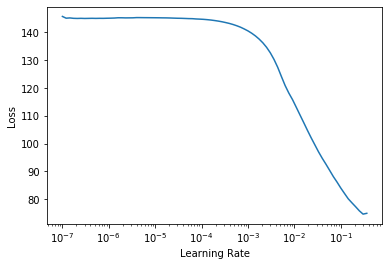

In [ ]:
%%time
learn.lr_find()

Running the following cell a few times and storing the model if it is better than the previous one

In [ ]:
%%time
learn.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,time
0,144.087646,143.782852,00:00
1,139.533264,135.234024,00:00
2,116.989449,51.462757,00:00
3,103.117905,55.099861,00:00
4,84.272270,62.621880,00:00


CPU times: user 2.03 s, sys: 1.67 s, total: 3.7 s
Wall time: 578 ms


In [ ]:
learn.save("model-1")

CPU times: user 26.2 s, sys: 22.1 s, total: 48.4 s
Wall time: 7.46 s


(0.014454397559165954, 2.5118865210060903e-07)

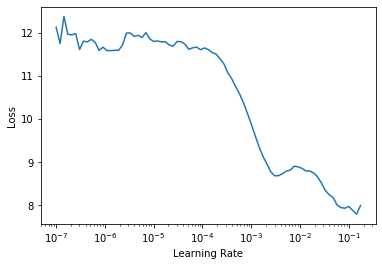

In [ ]:
%%time
learn.lr_find()

In [ ]:
#hide
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,12.523651,67.456451,00:00
1,12.054108,65.857628,00:00
2,10.326270,61.953407,00:00
3,8.422761,58.765785,00:00
4,7.169534,57.351788,00:00


In [ ]:
#hide
learn.save("model-2")

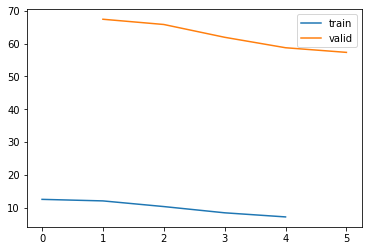

In [ ]:
learn.recorder.plot_loss(skip_start=0)

In [ ]:
#hide
learn.save("model-final")

Collecting predictions, `y_pred`, and ground truth, `y_true`, for all observations to approximate Kaggle's model evaluation.

In [ ]:
y_pred, y_true = learn.get_preds()

y_pred[:5], y_true[:5]

(tensor([[4.6112],
         [4.5001],
         [3.3700],
         [4.7818],
         [4.3316]]),
 tensor([[12.2006],
         [11.2252],
         [12.0377],
         [12.0963],
         [12.0782]]))

In [ ]:
#export
def predictions_vs_true_distribution_plots(y_pred:torch.Tensor, y_true:torch.Tensor, dep_var:str, bins:int=50):
    "Plots the predicted and true distributions side by side plus the residuals distribution"
    _y_p = y_pred.detach().numpy().ravel()
    _y_t = y_true.detach().numpy().ravel()

    fig, axs = plt.subplots(ncols=2, figsize=(14,4))
    ax = axs[0]
    ax.hist(_y_p, bins=bins, alpha=.5, label="pred")
    ax.hist(_y_t, bins=bins, alpha=.5, label="true")
    ax.set_xlabel(f"{dep_var}")
    ax.set_title(f"predicted vs true '{dep_var}'")
    ax.legend()

    ax = axs[1]
    ax.hist(_y_p-_y_t, bins=bins)
    ax.set_xlabel("Δ")
    ax.set_title(f"Δ-distribution: mean = {(_y_p-_y_t).mean():.2f}, std = {np.std(_y_p-_y_t):.2f}")
    plt.show()

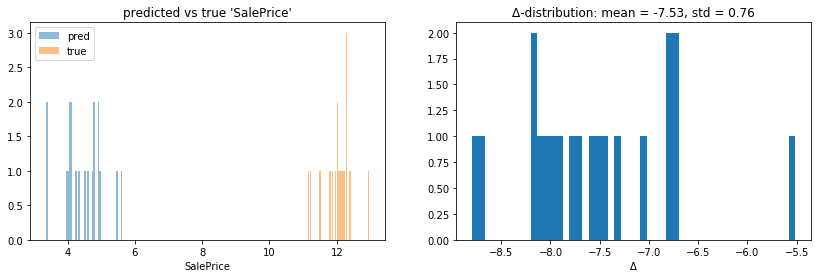

CPU times: user 422 ms, sys: 15.6 ms, total: 438 ms
Wall time: 452 ms


In [ ]:
%%time
predictions_vs_true_distribution_plots(y_pred, y_true, dep_var, bins=50)

Score of the current model predictions vs compared to the public leaderboard

,TeamId,TeamName,SubmissionDate,Score
7590,4210573,hsuanpingsun,2020-01-04 03:44:55,0.0
10044,4278029,Muhammet İkbal Elek,2020-01-20 13:09:34,0.0
9856,3740535,wentixiaogege,2020-01-19 03:37:57,0.0
4988,4155989,terracoda,2019-12-20 12:56:53,0.0
15086,2248598,predictor!,2020-02-15 13:51:49,0.0


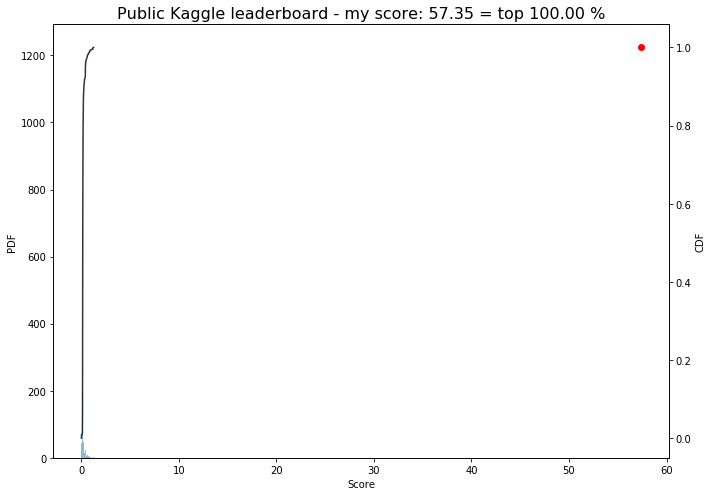

In [ ]:
my_score = loss_fun(y_pred, y_true).item()

show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, user_score=my_score, user="my")